# Insurance Regression Project

### Main Objective

The project will be focused on using regression to predict the "charges" target values of an insurance dataset based on different features. This analysis could be benefitial to find patterns within the data, and see if certain values on certain features affect the insurance charges of each individual.

To make this possible we are going to make four different regression models, those being: <b>Linear Regression, Lasso Regression, Ridge Regression and Elastic Net</b>, all of them are going to have:
- <b>Polynonial Features
- Standar Scaling
- Cross Validation</b>

### Import the required libraries


In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Dataset


In [3]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


There are not "null" values in the dataset, so there is no necessity to impute data

### About the Data

The data we are working with is a Medical Cost Personal Dataset, it has more then 1300 entries and 7 features including the target of the prediction model, charges, that is going to be developed within this project.

### Columns

- age: age of the beneficiary
- sex: the gender of the contractor
- bmi: the body mass index
- children: number of children covered by the health insurance
- smoker: if the beneficiary is a smoker or not
- region: the beneficiary´s residencial area: northeast, northwest, southeast, southwest
- charges: individual medical cost billed by insurance

Transform categorical data into a more numerical form

In [ ]:

le = LabelEncoder()
# Male or Female
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# Smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#Region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)


We are going to plot two distplot to see the distribution of the data before and after a log transformation

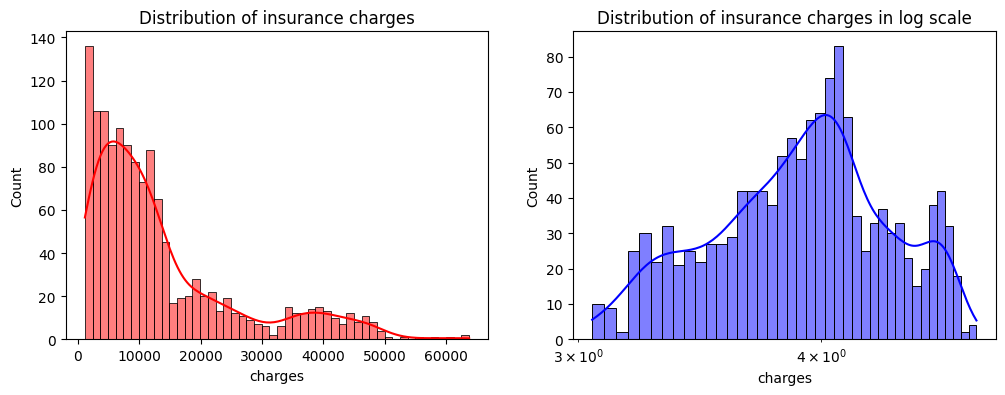

In [7]:
plt.figure(figsize=(12,4))

ax=plt.subplot(121)
sns.histplot(data['charges'],bins=50,color='r',ax=ax, kde=True)
ax.set_title('Distribution of insurance charges')

ax=plt.subplot(122)
sns.histplot(np.log10(data['charges']),bins=40,color='b',ax=ax, kde=True)
ax.set_title('Distribution of insurance charges in log scale')
ax.set_xscale('log')

Now we are going to use the Shapiro test to check if the data is normally distributed, if the pvalue of the result is greater that 0.05. then we can say that the data is normally distributed.

In [8]:
sh_charges = shapiro(data['charges'])
sh_charges

ShapiroResult(statistic=0.8146881157362383, pvalue=1.1505226334932036e-36)

The data without transformations has a pvalue of <b>≈ 1.15e-36</b>, this means the data is not normally distributed. Now we are going to use the Shapiro test to check if the data is normally distributed with a log transformation

In [9]:

sh_log_charges = shapiro(np.log(data['charges']))
sh_log_charges

ShapiroResult(statistic=0.9831647614892022, pvalue=2.291335899652065e-11)

Doing a log transformations changes the data to a more normal distribution, there are better methods to distribute the data like the Quantile Transformer from the SkLearn preprocessing library that makes the pvalue of the shapiro test 0.001, still not completely normal distributed, but a better result, but in this case a log transformation gives us a better R^2 Score and MSE score when writting our models, so we are going to leave it with this log transformation.


In [10]:
data['charges'] = np.log(data['charges'])

We are going to create a heatmap just to see the correlation of the diferent features


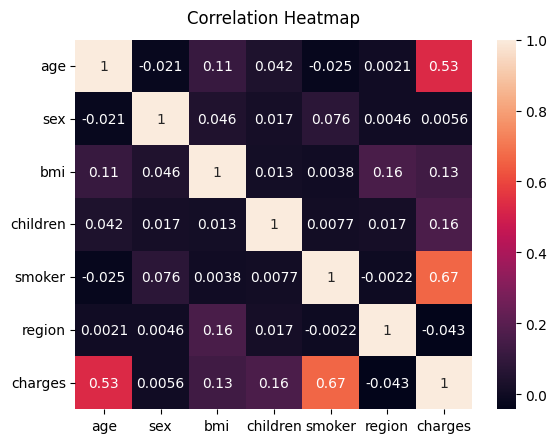

In [11]:
plt.figure()
sns.heatmap(data.corr(), annot=True).set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

We can see that the feature with a bigger correlation with out target is the smoker, followed by age, so we are going to make a violin plot to see just how much is that correlation.


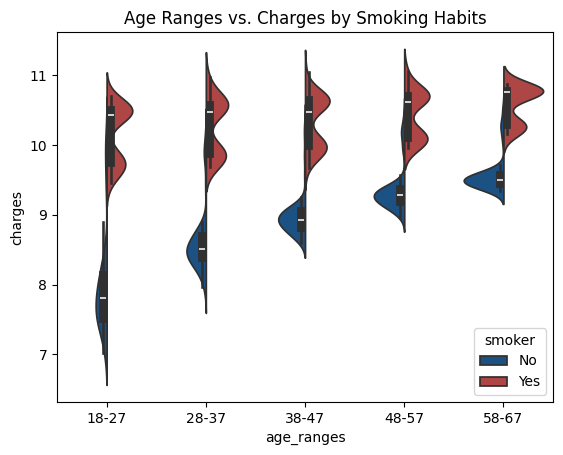

In [12]:
df_ages = data.copy()
age_ranges = range(18, 74, 10)
age_labels = [f'{i}-{i+9}' for i in age_ranges[:-1]]
df_ages['age_ranges'] = pd.cut(df_ages['age'], bins=age_ranges, labels=age_labels, right=False)
df_ages['smoker'] = df_ages['smoker'].map({1: 'Yes', 0: 'No'})

my_pal = {smoker: "#c03434" if smoker == "Yes" else "#0b5394" for smoker in df_ages["smoker"].unique()}

plt.figure()
sns.violinplot(data= df_ages, x='age_ranges', y='charges', hue='smoker', hue_order=['No', 'Yes'], split=True, palette= my_pal).set_title('Age Ranges vs. Charges by Smoking Habits')
plt.show()

As we can see, in all age groups, the charges are bigger when the individual is a smoker, and there is also a slight curve based in the ages, where the older is the beneficiary the charges increase.

### Regression Models

First we separate the independet variables from the target, then we call an instance of Standar Scaler, KFold for the cross validation and a range of aplphas and l1 ratios, again, to be used in the GridSearchCV


In [13]:
# Independet variable
X = data.drop('charges',axis=1)
# Dependent variable
y = data['charges']

#Standar Scaler
ss = StandardScaler() 

#KFold for the Cross Validation, shuffled and wit four splits
kf = KFold(shuffle=True, random_state=23, n_splits=4)

#Alphas and l1 ratios for the GridSearchCV
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
l1_ratios = np.linspace(0.1, 0.9, 9)

#### GridSearchCV for the LINEAR REGRESSION, checking the Polynomial Degree:

In [15]:
estimator = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("linear_regression", LinearRegression())])

params = {
    'polynomial_features__degree': [1, 2, 3, 4, 5, 6]

}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)

print('GridSearchCV Best Score:', grid.best_score_)
print('GridSearchCV Best Params:', grid.best_params_)
print('Mean Squared Error:', mean_squared_error(y, grid.predict(X)))


GridSearchCV Best Score: 0.8333848249313076
GridSearchCV Best Params: {'polynomial_features__degree': 2}
Mean Squared Error: 0.13445590699384274


The GridSeachCV gave us an answer where the best Polynomial Degree is 3, so we are going to make the model based on that. Being the cross validation a shuffled KFold, the R2 Score and MSE might change a little, but not in a drastic way.

In [16]:
pipe_lr = Pipeline([('pf', PolynomialFeatures(degree=3)), ('ss', StandardScaler()), ('lr', LinearRegression())])
lr_predictions = cross_val_predict(pipe_lr, X, y, cv=kf)

lr_r2_score = r2_score(y, lr_predictions)
lr_mse = mean_squared_error(y, lr_predictions)
print('R^2 SCORE LINEAR REGRESSION:', lr_r2_score)
print('MSE LINEAR REGRESSION:', lr_mse)

R^2 SCORE LINEAR REGRESSION: 0.833373377406771
MSE LINEAR REGRESSION: 0.14078252943660183


#### GridSearchCV for the LASSO REGRESSION, checking the Polynomial Degree and Alpha:

In [17]:
estimator = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("lasso_regression", Lasso())])

params = {
    'polynomial_features__degree': [1, 2, 3, 4, 5, 6],
    'lasso_regression__alpha': alphas

}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)

print('GridSearchCV Best Score:', grid.best_score_)
print('GridSearchCV Best Params:', grid.best_params_)
print('Mean Squared Error:', mean_squared_error(y, grid.predict(X)))

GridSearchCV Best Score: 0.8270199093602366
GridSearchCV Best Params: {'lasso_regression__alpha': 0.005, 'polynomial_features__degree': 6}
Mean Squared Error: 0.13836636376792372


The GridSeachCV gave us an answer where the best Polynomial Degree is 6 and the best Alpha is 0.005, so we are going to make the model based on that. Being the cross validation a shuffled KFold, the R2 Score and MSE might change a little, but not in a drastic way.

In [21]:
pipe_lasso = Pipeline([('pf', PolynomialFeatures(degree=6)), ('ss', StandardScaler()), ('lasso', Lasso(alpha=0.005, max_iter=10000))])
lasso_predictions = cross_val_predict(pipe_lasso, X, y, cv=kf)

lasso_r2_score = r2_score(y, lasso_predictions)
lasso_mse = mean_squared_error(y, lasso_predictions)
print('R^2 SCORE LASSO REGRESSION:', lasso_r2_score)
print('MSE LASSO REGRESSION:', lasso_mse)

R^2 SCORE LASSO REGRESSION: 0.8297070102298103
MSE LASSO REGRESSION: 0.14388023637552189


#### GridSearchCV for the RIDGE REGRESSION, checking the Polynomial Degree and Alpha:

In [22]:
estimator = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3, 4, 5, 6],
    'ridge_regression__alpha': alphas

}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)

print('GridSearchCV Best Score:', grid.best_score_)
print('GridSearchCV Best Params:', grid.best_params_)
print('Mean Squared Error:', mean_squared_error(y, grid.predict(X)))

GridSearchCV Best Score: 0.8334133670531578
GridSearchCV Best Params: {'polynomial_features__degree': 2, 'ridge_regression__alpha': 0.3}
Mean Squared Error: 0.13336689366739207


The GridSeachCV gave us an answer where the best Polynomial Degree is 2 and the best Alpha is 0.3, so we are going to make the model based on that. Being the cross validation a shuffled KFold, the R2 Score and MSE might change a little, but not in a drastic way.

In [23]:
pipe_ridge = Pipeline([('pf', PolynomialFeatures(degree=2)), ('ss', StandardScaler()), ('ridge', Ridge(alpha=1))])
ridge_predictions = cross_val_predict(pipe_ridge, X, y, cv=kf)

ridge_r2_score = r2_score(y, ridge_predictions)
ridge_mse = mean_squared_error(y, ridge_predictions)
print('R^2 SCORE RIDGE REGRESSION:', ridge_r2_score)
print('MSE RIDGE REGRESSION:', ridge_mse)

R^2 SCORE RIDGE REGRESSION: 0.8361092160394062
MSE RIDGE REGRESSION: 0.13847102436713268


#### GridSearchCV for the ELASTIC NET REGRESSION; checking the Polynomial Degree, Alpha and L1 Ratio:

In [24]:
estimator = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("elasticNet", ElasticNet(max_iter=1000))])

params = {
    'polynomial_features__degree': [1, 2, 3, 4, 5, 6],
    'elasticNet__alpha': alphas,
    'elasticNet__l1_ratio': l1_ratios
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y)

print('GridSearchCV Best Score:', grid.best_score_)
print('GridSearchCV Best Params:', grid.best_params_)
print('Mean Squared Error:', mean_squared_error(y, grid.predict(X)))

GridSearchCV Best Score: 0.8318698434955865
GridSearchCV Best Params: {'elasticNet__alpha': 0.005, 'elasticNet__l1_ratio': 0.1, 'polynomial_features__degree': 2}
Mean Squared Error: 0.1349268084442058


The GridSeachCV gave us an answer where the best Polynomial Degree is 2, the best Alpha is 0.005 and the best L1 Ratio is 0.1; so we are going to make the model based on that. Being the cross validation a shuffled KFold, the R2 Score and MSE might change a little, but not in a drastic way.

In [25]:
pipe_elasticNet = Pipeline([('pf', PolynomialFeatures(degree=2)), ('ss', StandardScaler()), ('elasticNet', ElasticNet(alpha=0.005, l1_ratio=0.1))])
elasticNet_predictions = cross_val_predict(pipe_elasticNet, X, y, cv=kf)

elasticNet_r2_score = r2_score(y, elasticNet_predictions)
elasticNet_mse =  mean_squared_error(y, elasticNet_predictions)
print('R^2 SCORE ELASTIC NET REGRESSION:', elasticNet_r2_score)
print('MSE ELASTIC NET REGRESSION:', elasticNet_mse)

R^2 SCORE ELASTIC NET REGRESSION: 0.8345673240622797
MSE ELASTIC NET REGRESSION: 0.1397737660855902


### Recommended Model
We are going to compare the diferent R2 Scores and MSE of all the models so we can compare the results and find the one with better ajustment

In [26]:
labels = ['Linear', 'Lasso', 'Ridge', 'Elastic Net']
r2_scores = [lr_r2_score, lasso_r2_score, ridge_r2_score, elasticNet_r2_score]
mse = [lr_mse, lasso_mse, ridge_mse, elasticNet_mse]

regressions = list(zip(labels, r2_scores, mse))
regressions

[('Linear', 0.833373377406771, 0.14078252943660183),
 ('Lasso', 0.8297070102298103, 0.14388023637552189),
 ('Ridge', 0.8361092160394062, 0.13847102436713268),
 ('Elastic Net', 0.8345673240622797, 0.1397737660855902)]

Based in the results of all the models we can say that the best one to predict the charges feature is the Ridge Regression, even if the scores of all the models have very similar R^2 Scores and MSE, Ridge Regression managed to get a little higher R^2 with 0.836 and a lower MSE than the other models with 0.138, making it the best adjusted model of all that were tried.

#### Next Steps


The next steps for the project could be trying to find better ways to normally distribute the data where the pvalue of the Shapiro Test is greater than 0.05, there is also the possibility of using different linear models, like ARD Regression or Bayesian Ridge.